# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [266]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy.solvers import solve
# for later use, in order to write tilde-variables, we need the following package
from sympy import *
sm.init_printing()
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Model description**

**The Solow model with human kapital** 

The extendet Solow model contain the following variables
1. $K_t$ is physical capital
2. $H_t$ is human capital
3. $A_t$ is technology
4. $L_t$ is labour

The production function
$$
Y_t = K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}, \quad 0<\alpha<1, 0<\varphi<1, \alpha+\varphi<1
$$

The household decides how much to save of physical capital and of human capital as a constant fraction of income.
$$
S_t = (s_K + s_H)Y_t, \quad s_K+s_H<1
$$

$s_K$ denotes the savings rate of physical capital and $s_H$ denotes the savings of human capital

This lead to the accumulation of phycial capital
$$
K_{t+1}=s_KY_t+(1-\delta)K_t, \quad K_0 \, \text{given}
$$

As well as the accumulation of human capital
$$
H_{t+1}=s_HY_t+(1-\delta)H_t, \quad H_0 \, \text{given}
$$

Further more the accumulation of technology and labour is defined as following
$$
A_{t+1} = (1+g)A_t, \quad A_0 \, \text{given}
$$
$$
L_{t+1} = (1+n)L_t, \quad L_0 \, \text{given}
$$
Where  $g$ is a constant rate of techonolical progress, and $n$ is the population growth.

We define the following tilde-variables, which is the techonogy adjusted variables.
$$
\tilde{y}_{t}= \frac{Y_t}{A_tL_t}
$$
$$
\tilde{k}_{t}= \frac{K_t}{A_tL_t}
$$
$$
\tilde{h}_{t}= \frac{H_t}{A_tL_t}
$$

The **production function** has **constant return to scale** meaning that
$$
\frac{Y_t}{A_tL_t} = \frac{K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}}{A_tL_t}=\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}
$$

We are then left with two transistion equations. One equation for physical capital and one equation for human capital.
$$
\tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{k}_{t})
$$
$$
\tilde{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{h}_{t})
$$



## **Analytical solution**

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

We then assume that $\tilde{k}_{t+1} = \tilde{k}_{t} =\tilde{k}^{*}$ and $\tilde{h}_{t+1} = \tilde{h}_{t} =\tilde{h}^{*}$. We are then left with a system of two equation with 2 unnowns. 

$$
\tilde{k}^{*} = \frac{1}{(1+n)(1+g)}(s_K(\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}+(1-{\delta})\tilde{k}^{*})
$$
$$
\tilde{h}^{*} = \frac{1}{(1+n)(1+g)}(s_H(\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}+(1-{\delta})\tilde{h}^{*})
$$

We now use sympy to solve this system, to optain the steady state for $\tilde{k}^{*}$ and $\tilde{h}^{*}$

In [267]:
# defining all variables
ktilde = sm.symbols('ktilde')
htilde = sm.symbols('htilde')
sK = sm.symbols('s_K')
sH = sm.symbols('s_H')
delta = sm.symbols('delta')
g = sm.symbols('g')
n = sm.symbols('n')
alpha = sm.symbols('alpha')
varphi = sm.symbols('varphi')

f = (ktilde**alpha)*(htilde**varphi) # defining f


# define transistion equations
tranK = sm.Eq(ktilde, 1/((1+n)*(1+g))*(sK*ktilde**alpha*htilde**varphi+(1-delta)*ktilde))
tranH = sm.Eq(htilde, 1/((1+n)*(1+g))*(sH*ktilde**alpha*htilde**varphi+(1-delta)*htilde))

display(tranK)
display(tranH)

tranK = sm.simplify(tranK)
tranH = sm.simplify(tranH)

display(tranK)
display(tranH)


ss = sm.solve([tranK,tranH],[ktilde,htilde])[0]

#SPØRG ANNE SOFIE
# solve for steady state
#ss = sm.solve(tranK, ktilde)
#ssh_k = sm.solve(tranH,)[0]

     varphi  α                
    h̃      ⋅k̃ ⋅s_K + k̃⋅(1 - δ)
k̃ = ──────────────────────────
         (g + 1)⋅(n + 1)      

                 varphi  α    
    h̃⋅(1 - δ) + h̃      ⋅k̃ ⋅s_H
h̃ = ──────────────────────────
         (g + 1)⋅(n + 1)      

     varphi  α                
    h̃      ⋅k̃ ⋅s_K - k̃⋅(δ - 1)
k̃ = ──────────────────────────
         (g + 1)⋅(n + 1)      

                  varphi  α    
    -h̃⋅(δ - 1) + h̃      ⋅k̃ ⋅s_H
h̃ = ───────────────────────────
          (g + 1)⋅(n + 1)      

NotImplementedError: could not solve ktilde*(delta - 1) + ktilde*(g + 1)*(n + 1) - ktilde**alpha*s_K*(((delta + g*n + g + n)/(ktilde**alpha*s_H))**(1/(varphi - 1)))**varphi

## **Numerical solution**

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

**Algorithm:**
1. Define model parameters: savings rate in physical capital (*sK*), savings rate in human capital (*sH*), depreciation rate (*delta*), technological growth rate (*g*), population growth rate (*n*), return on physical capital (*alpha*) and return on human capital (*varphi*).
2. Define the steady-state expressions for physical capital, k_star, and human capital, h_star, as functions of the inputs ktilde and htilde.
3. Define the objective function, as a function that returns a list of the values of k_star and h_star evaluated at the input values ktilde and htilde.
4. Define an initial guess for the values of ktilde and htilde, x0.
5. Call the scipy.optimize.root function, passing the objective function, initial guess, and the method="krylov" argument. Assign the output to a variable.
6. Check the convergence of the solver by checking the value of the success field in the output variable, solution. **If success is True, the solver has converged; otherwise, it has not.**
7. **Extract the values of ktilde and htilde from the x field of the solution variable.**
8. **Return the values of ktilde and htilde as the solution to the model.**

Based on "Introducing advanced macroeconomic" we find the plauseble values for out parameters. 
We assume a total savings rate of 20%, allined with teory, and therefor assume a savingsrate of 10% for each physical and human capital. We also have $\delta$ + $g$ should be 0,75, hence the values for the parameters is $\delta$ = 5% and $g$ = 2,5%. The population is assumed to increase with 10%. $\alpha$ and $\varphi$ is usual estimated to be $\frac{1}{3}$.


In [269]:
# set parameters
sK = 0.1
sH = 0.1
delta = 0.05
g = 0.025
n = 0.01
alpha = 1/3
varphi = 1/3

In [270]:
def steady_state(sK, sH, delta, g, n, alpha, varphi):
    """ root finding function

    Args:
        ktilde (float): physical capital per effective worker
        htilde (float): human capital per effective worker
        sK (float): savings rate in physical capital
        sH (float): savings rate in human capital
        delta (float): depreciation rate
        g (float): technological growth rate
        n (float): population growth
        alpha (float): return of physical capital
        varphi (float): return of human capital

    Returns:

    """
    
    # define steady state expressions for k* and h* - both expressions depend on ktilde and htilde
    k_star = lambda ktilde, htilde: ((1/((1+n)*(1+g)))*(sK*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*ktilde))
    h_star = lambda ktilde, htilde: ((1/((1+n)*(1+g)))*(sH*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*htilde))

    # initial guess
    x0 = [1,1]
    
    # join k_star and h_star as a non-linear system to find roots
    objective = lambda x: [k_star(x[0], x[1]), h_star(x[0], x[1])]

    # solving for roots
    solution = optimize.root(objective, x0, method="krylov") # using the Newton-Krylov solver - can deal with large non-linear problems
    
    ss_k = solution.x[0]
    ss_h = solution.x[1]

    return ss_k, ss_h, solution.nit

# save valyes of ss_k, ss_h and nit (number of iterations)
ss_k, ss_h, nit = steady_state(sK, sH, delta, g, n, alpha, varphi)


c:\Users\cecil\anaconda3\lib\site-packages\scipy\optimize\_nonlin.py:366: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


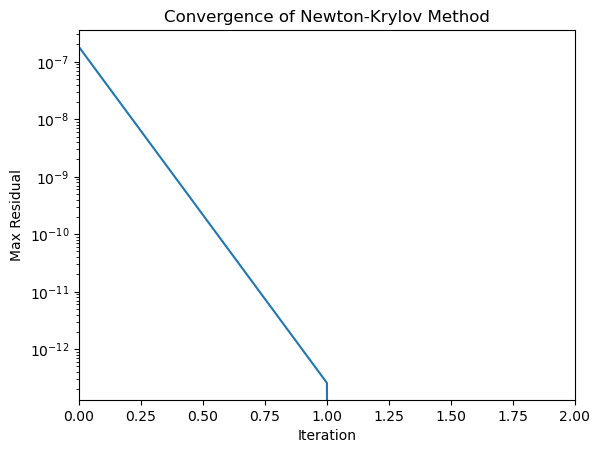

In [271]:
residuals = []
xk = [1,1]
for i in range(10):
    sol = optimize.root(objective, xk, method='krylov')
    xk = sol.x
    residuals.append(abs(sol.fun).max())

# plot residuals
plt.plot(residuals)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Max Residual')
plt.xlim(0,2)
plt.title('Convergence of Newton-Krylov Method')
plt.show()

Now we have the steady state values of physical and human capital. We can now compute the steady state value of GDP per effective worker:
$$
\tilde{y}^{*} = (\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}
$$

In [272]:
def y_steady_state(ss_k, ss_h, alpha, varphi):
    """ calculate GDP per effective worker in steady state

    Args:
        ss_k (float): steady state value of physical capital per effective worker
        ss_h (float): steady state value of human capital per effective worker
        alpha (float): return of physical capital
        varphi (float): return of human capital

    Returns:
        ss_y (float): steady state value of GDP per effective worker

    """
    # define steady state value for y
    ss_y = ss_k**alpha*ss_h**varphi

    return ss_y

# save value of ss_y
ss_y = y_steady_state(ss_k, ss_h, alpha, varphi)

# **Further analysis**

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

In [ ]:
# define solow equation and set them equal to 0
dktilde = sm.Eq(0,(1/((1+n)*(1+g)))*(sK*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*ktilde))
dhtilde = sm.Eq(0,(1/((1+n)*(1+g)))*(sH*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*htilde))
# solve for htilde (=nullclines)
null_dktilde = sm.solve(dktilde, htilde)
null_dhtilde = sm.solve(dhtilde, htilde)
# check nullclines
print(f'ktilde = {null_dktilde}')
print(f'htilde = {null_dhtilde}')
# we see that htilde has three solutions: we want to use the positive solution
#null_dhtilde = null_dhtilde[2]
print(f'htilde = {null_dhtilde}')

ktilde = [(ktilde**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/varphi)]
htilde = [((delta + g*n + g + n)/(ktilde**alpha*s_H))**(1/(varphi - 1))]
htilde = [((delta + g*n + g + n)/(ktilde**alpha*s_H))**(1/(varphi - 1))]


C:\Users\cecil\AppData\Local\Temp\ipykernel_12972\4069097752.py:5: RuntimeWarning: divide by zero encountered in divide
  return ((delta + g*n + g + n)/(ktilde**alpha*sH))**(1/(varphi - 1))


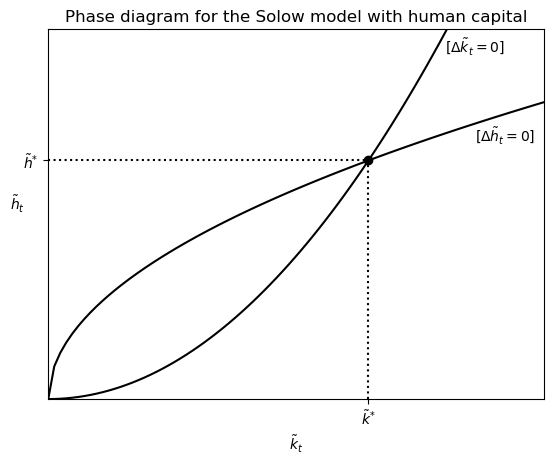

In [313]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1,1,1)
# create grid
k_range = np.linspace(0,3,100)
h_range = np.linspace(0,3,100)
k_grid, h_grid = np.meshgrid(k_range, h_range)

# define range for ktilde
ktilde = np.linspace(0,3,100)

# plot null_k and null_h
ax.plot(ktilde, null_k(ktilde), color='black')
ax.plot(ktilde, null_h(ktilde), color='black')
# alterations to figure
plt.xlim(0,2.5)
plt.ylim(0,2.5)
ax.set_xlabel(r'$\tilde{k}_{t}$')
ax.set_ylabel(r'$\tilde{h}_{t}$', rotation=0)
ax.set_title("Phase diagram for the Solow model with human capital")
plt.text(2.0, 2.35, r'[$\Delta \tilde{k}_{t}=0$]')
plt.text(2.15, 1.75, r'[$\Delta \tilde{h}_{t}=0$]')
# insert steady state
plt.scatter(ss_k, ss_h, color='black')
# remove ticks
ax.set_xticks(xtick_loc)
ax.set_yticks(ytick_loc)
# set x tick
xtick_loc=[ss_k]
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = r'$\tilde{k}^{*}$'
ax.set_xticklabels(labels)
# set y tick
ytick_loc=[ss_h]
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$\tilde{h}^{*}$'
ax.set_yticklabels(labels)
# insert dotted lines from axes to steady state
plt.axvline(ss_k, ymax=ss_h/2.5, linestyle='dotted', color='black')
plt.axhline(ss_h, xmax=ss_k/2.5, linestyle='dotted', color='black')


# Conclusion

Add concise conclusion. 